# Imports & Loading corpus

In [1]:
import json
import bz2
import re
from bz2 import BZ2File
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy

%matplotlib inline
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc

from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

import seaborn as sns
sns.set_context('notebook')
sns.set(rc = {'figure.figsize':(10,7)})

In [2]:
df_corpus = pd.read_json('corpus.json.bz2', compression = 'bz2')
df_corpus_OPEP = pd.read_json('corpus_OPEP.json.bz2', compression = 'bz2')
df_corpus_petrole = pd.read_json('corpus_petrole.json.bz2', compression = 'bz2')
df_corpus_compagnies = pd.read_json('corpus_compagnies.json.bz2', compression = 'bz2')
df_depeches = pd.read_json('corpus_depeches.json.bz2', compression = 'bz2')
df_not_depeches = pd.read_json('corpus_not_depeches.json.bz2', compression = 'bz2')

In [3]:
df_corpus['journal'] = df_corpus['journal'].astype('category')
df_corpus_OPEP['journal'] = df_corpus_OPEP['journal'].astype('category')
df_corpus_petrole['journal'] = df_corpus_petrole['journal'].astype('category')
df_corpus_compagnies['journal'] = df_corpus_compagnies['journal'].astype('category')

df_corpus.index = np.arange(len(df_corpus))
df_corpus_OPEP.index = np.arange(len(df_corpus_OPEP))
df_corpus_petrole.index = np.arange(len(df_corpus_petrole))
df_corpus_compagnies.index = np.arange(len(df_corpus_compagnies))

In [4]:
df_total = pd.read_json('total.json.bz2', compression = 'bz2')
df_total['journal'] = df_total['journal'].astype('category')
df_total.index = np.arange(len(df_total))

In [5]:
df_corpus.head()

,journal,date,page,ppage,text,length,keyword_volvo,keyword_nyse,keyword_nestlé,keyword_heineken,...,keyword_gulf oil,keyword_ats,keyword_afp,keyword_reuter,keyword_reuther,keywords_petrole,keywords_OPEP,keywords_compagnies,keywords,depeches
0,JDG,1974-01-07,2,NaN,"Pétrole : "" (déjà 50000 la crise continue chôm...",3465,0,0,0,0,...,0,2,1,0,0,6,5,0,11,3
1,JDG,1974-01-07,2,NaN,''« Je vendrai'Le chah d Iran : de l aspirine ...,1976,0,0,0,0,...,0,0,1,0,0,7,0,0,7,1
2,JDG,1974-10-21,5,NaN,ETRANGER-DIAGNOSTIC Iran-Irak : un vieux confl...,2484,0,0,0,0,...,0,3,0,0,0,2,0,0,2,3
3,JDG,1974-08-21,9,NaN,Du nouveau sous le soleil Nous pouvons remerci...,5930,0,0,0,0,...,0,4,0,0,0,4,0,0,4,4
4,JDG,1974-08-28,5,NaN,Investissements étrangers aux USA : + 20 % en ...,1712,0,0,0,0,...,0,3,1,0,0,3,0,0,3,4


# Type-token ratio analysis

In [7]:
def count_words(text):
    ''' Returns the word (i.e. type) count for a given text.
    
    Input:
        text(str)
    
    Output:
        count_words(pandas DataFrame): return the count for each word
    '''
        
    words = re.split('[\s\.,·:;\'—«»*]', text)
    count_words = pd.Series(words).value_counts()
    
    count_words = pd.DataFrame(count_words).rename(columns = {0:'count'})
    
    length = []
    
    for word in count_words.index:
        length.append(len(word))
        
    count_words['length'] = length
    
    return count_words

In [7]:
def type_token_ratio(text, n_sample = 100, tokens = 1000):
    ''' Compute the type-token ratio (TTK) of a text, on n samples of same token length.
    
    Inputs:
        text(str): text/corpus
        n_sample(int): number of repeated measures
        tokens(int): number of tokens (words) of each TTK measure
    
    Output:
        type_token_ratio(list<float>): list of the TTK measures
    '''
    
    text.replace('([0-9])+', '')
    
    words_ = re.split('[\s\.,·:;\'—«»*]', str(text))
    words, type_token_ratio = [], []
    
    for word_ in words_:
        if word_ != '':
            words.append(word_)
        
    distribution = np.random.uniform(0, len(words) - tokens, n_sample).astype('int')
    
    for random in distribution :
        
        range_ = words[random:random + tokens]
        
        sample = ''
        for word in range_:
            sample += word + ' '
        
        type_ = len(count_words(sample)) - 1
        type_token_ratio.append(type_ / tokens)
        
    return type_token_ratio
    

In [58]:
def full_TTR(text, tokens = 1000):

    text.replace('([0-9])+', '')

    words_ = re.split('[\s\.,·:;\'—«»*•"\()0-9]', str(text))
    words_ = pd.Series(words_)
    words_ = words_[(words_ != '')]
    words_ = words_.reset_index().drop(columns = 'index').rename(columns = {0: 'word'})
    
    type_token_ratio = []
    
    bins = len(words_)//tokens
    
    for i in range(bins):
        
        type_ = len(words_.iloc[0+i*tokens:tokens+i*tokens].drop_duplicates())
        type_token_ratio.append(type_ / tokens)
    
    return type_token_ratio

Create sub-corpora with annual granularity

In [51]:
corpus_text = ''

for ind, row in df_corpus.iterrows():
    corpus_text += row['text']

In [52]:
len(corpus_text)

68571621

In [53]:
total_text = ''

for ind, row in df_total.iterrows():
    total_text += row['text']

In [54]:
len(total_text)

1005319864

In [12]:
distribution = np.random.uniform(0, len(total_text) - 50000, 1000).astype('int')
total_text_sample = ''

for i in distribution :
    total_text_sample += total_text[i:i+50000] + ' '

In [13]:
len(total_text_sample)

50001000

In [59]:
TTR_corpus = full_TTR(corpus_text, tokens = 1000)
TTR_total = full_TTR(total_text, tokens = 1000)

In [60]:
print(np.mean(TTR_corpus), np.mean(TTR_total))

0.49573880057803466 0.511709886507562


In [61]:
t_value, p_value = stats.ttest_ind(TTR_corpus, TTR_total)
print('p-value =', str(np.format_float_scientific(np.around(p_value, 6))))

p-value = 0.e+00


In [73]:
sns.set(rc={'figure.figsize':(16,16)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2)

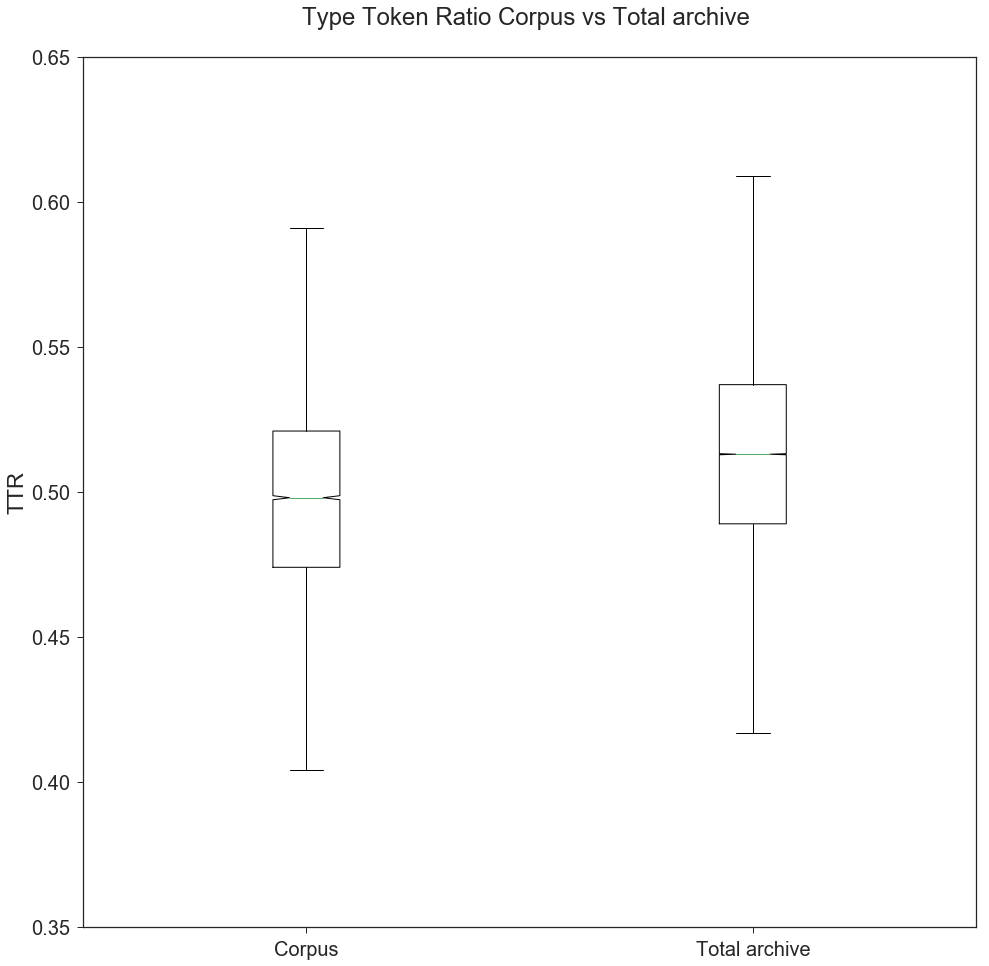

In [74]:
plt.boxplot([TTR_corpus, TTR_total], notch = True);

plt.xticks([1,2], np.array(['Corpus', 'Total archive']))
plt.ylabel('TTR');
plt.ylim((0.35,0.65))
plt.title('Type Token Ratio Corpus vs Total archive \n');
plt.show()

In [75]:
df_corpus['year'] = 0

for ind, row in df_corpus.iterrows():
    df_corpus['year'][ind] = row['date'].year

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [76]:
years = df_corpus['year'].value_counts().index.sort_values(ascending = True)

In [77]:
TTR_by_year = []

for year in years:
    df = df_corpus[df_corpus['year'] == year]
    
    text_year = ''
    
    for ind, row in df.iterrows():
        text_year += row['text']
        
    TTR_by_year.append(full_TTR(text_year, tokens = 1000))

In [78]:
np.arange(4)

array([0, 1, 2, 3])

In [92]:
sns.set(rc={'figure.figsize':(25,16)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2)

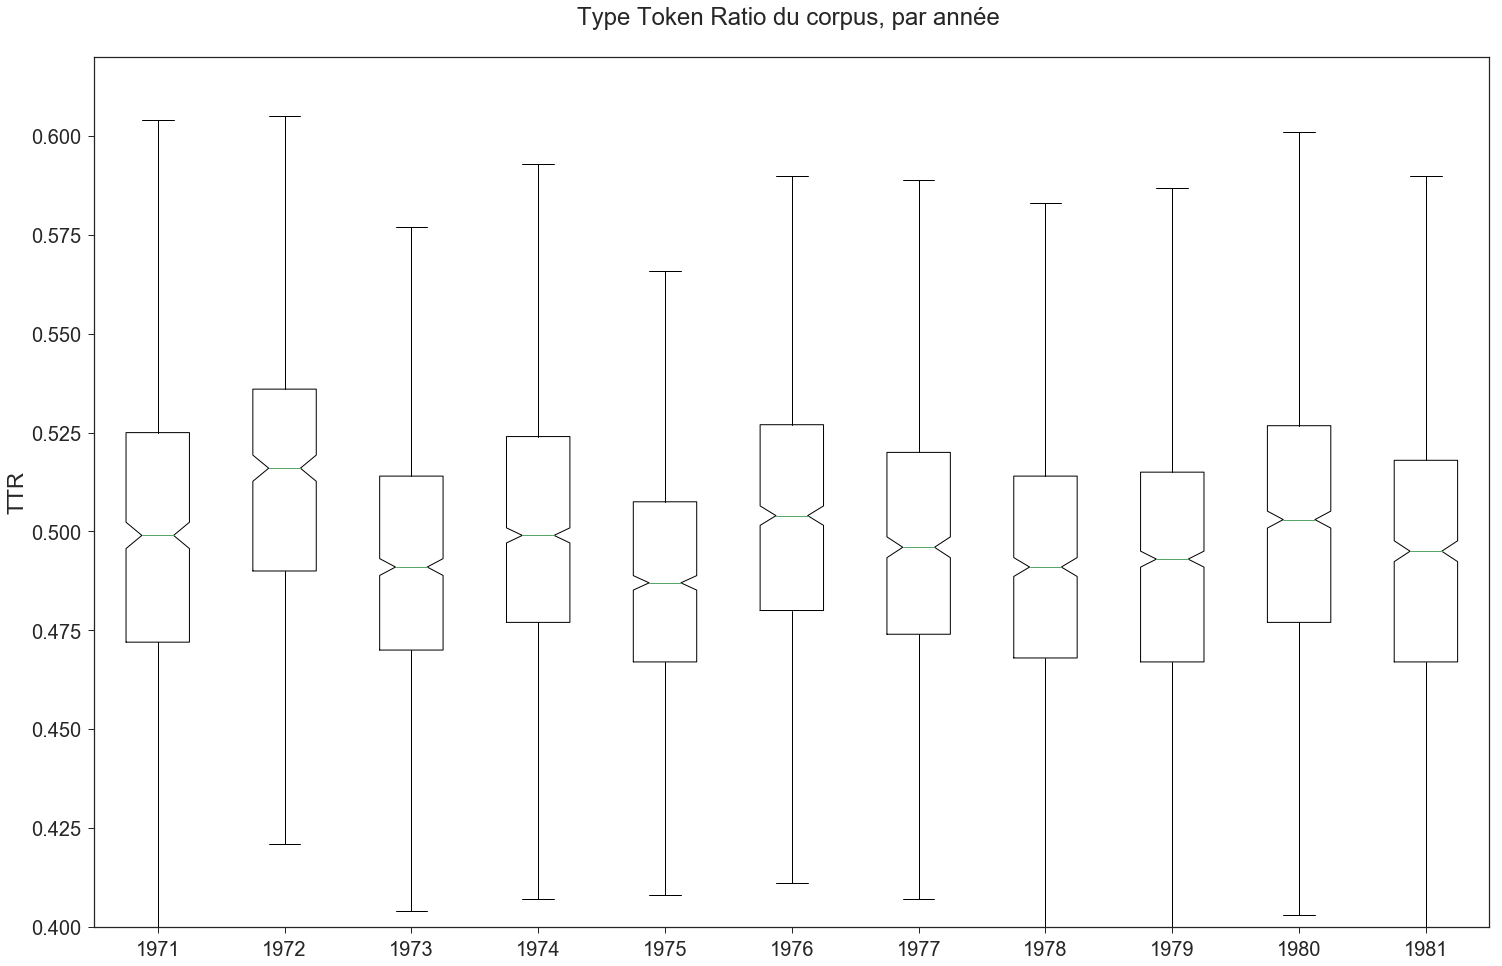

In [93]:
plt.boxplot(TTR_by_year, notch = True);

plt.xticks(np.arange(len(TTR_by_year))+1, years)
plt.ylabel('TTR');
plt.ylim((0.40,0.62))
plt.title('Type Token Ratio du corpus, par année \n');
plt.show()

In [80]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [81]:
lower_bound, mean, upper_bound = [], [], []

for i in range(len(TTR_by_year)):
    m, lb, ub = mean_confidence_interval(TTR_by_year[i])
    
    lower_bound.append(lb)
    mean.append(m)
    upper_bound.append(ub)

In [82]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("ticks")

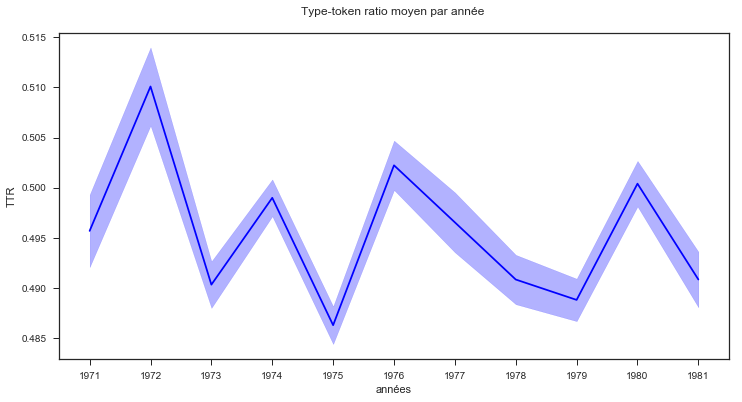

In [83]:
plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = 'b', alpha=.3)
plt.plot(mean, 'b')

plt.xticks(np.arange(len(years)), years)
plt.xlabel('années')
plt.ylabel('TTR')
plt.title('Type-token ratio moyen par année \n')

plt.show();

In [84]:
pages = df_corpus['page'].value_counts().index[:5]

In [85]:
TTR_pages = []

for page in pages:
    df = df_corpus[df_corpus['page'] == page]
    text = ''
    
    for ind, row in df.iterrows():
        text += row['text']
        
    TTR_pages.append(full_TTR(text, tokens = 1000))

In [96]:
sns.set(rc={'figure.figsize':(20,16)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2)

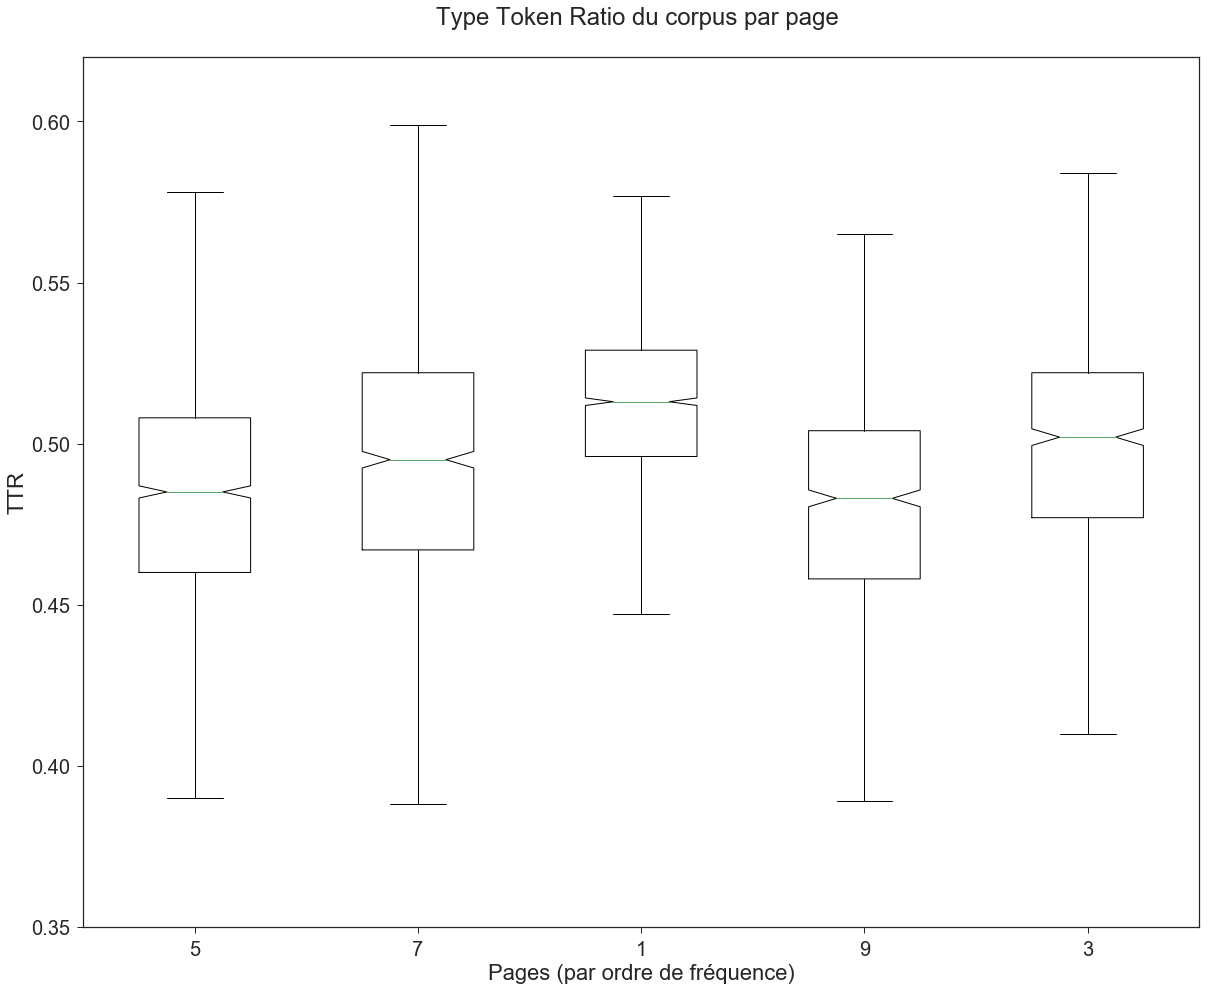

In [97]:
plt.boxplot(TTR_pages, notch = True);

plt.xticks(np.arange(len(TTR_pages))+1, pages)
plt.ylabel('TTR')
plt.xlabel('Pages (par ordre de fréquence)')
plt.ylim((0.35,0.62))
plt.title('Type Token Ratio du corpus par page \n');
plt.show()

# Sentiment analysis

In [98]:
#distr_corpus = np.random.uniform(0, len(df_corpus) - 1, 10000).astype('int')

tb_corpus = ''
subjectivity_corpus, polarity_corpus = [], []

#for i in distr_corpus:
for i in range(len(df_corpus)):
    blob = TextBlob(df_corpus['text'][i], pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
    subjectivity_corpus.append(blob[0])
    polarity_corpus.append(blob[1])

In [100]:
#distr_total = np.random.uniform(0, len(df_total) - 1, 10000).astype('int')

tb_total = ''
subjectivity_total, polarity_total = [], []

#for i in distr_total:
for i in range(len(df_total)):
    blob = TextBlob(df_total['text'][i], pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
    subjectivity_total.append(blob[0])
    polarity_total.append(blob[1])

In [101]:
t_value, p_value = stats.ttest_ind(subjectivity_corpus, subjectivity_total)
print('p-value =', str(np.format_float_scientific(np.around(p_value, 3))))

p-value = 0.e+00


In [102]:
t_value, p_value = stats.ttest_ind(polarity_corpus, polarity_total)
print('p-value =', str(np.format_float_scientific(np.around(p_value, 10))))

p-value = 0.e+00


In [103]:
print(np.mean(subjectivity_corpus), np.mean(subjectivity_total))
print(np.mean(polarity_corpus), np.mean(polarity_total))

0.07089046632808131 0.0751045988279457
0.1893511148025695 0.20236631531642696


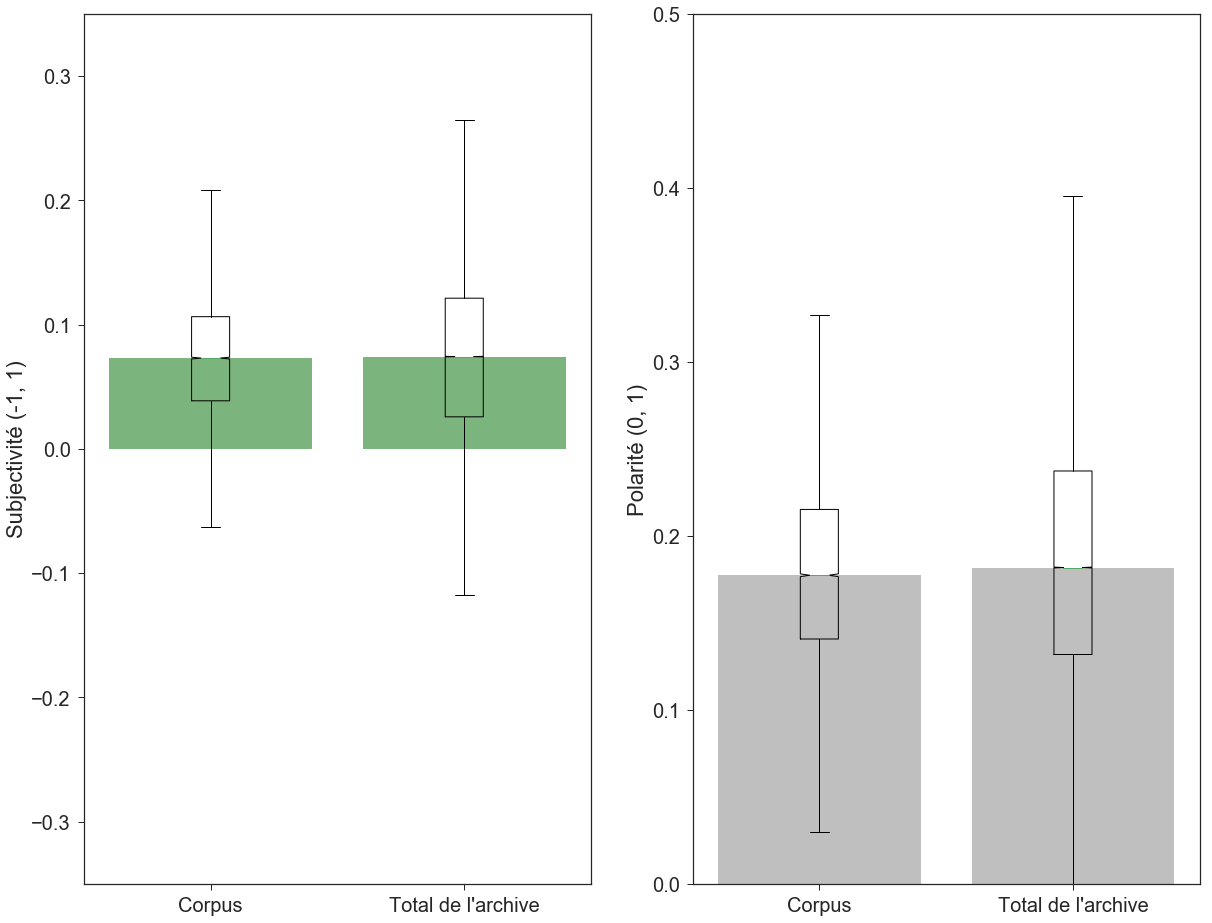

In [104]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar([1, 2], [np.median(subjectivity_corpus), np.median(subjectivity_total)], color = '#7CB47D')
ax1.boxplot([subjectivity_corpus, subjectivity_total], notch = True);

ax2.bar([1, 2], [np.median(polarity_corpus), np.median(polarity_total)], color = '#BFBFBF')
ax2.boxplot([polarity_corpus, polarity_total], notch = True);

ax1.set_ylim((-0.35, 0.35))
ax2.set_ylim((0, 0.5))

ax1.set_ylabel('Subjectivité (-1, 1)')
ax2.set_ylabel('Polarité (0, 1)')

ax1.set_xticklabels(['Corpus', 'Total de l\'archive'])
ax2.set_xticklabels(['Corpus', 'Total de l\'archive'])

plt.show();

In [115]:
subjectivity, polarity = [], []
median_subj, median_pol = [], []

for year in years:
    #distribution = np.random.uniform(0, len(df_corpus[df_corpus['year'] == year]) - 1, 5000).astype('int')
    
    subjectivity_, polarity_ = [], []
    
    df_ = df_corpus[df_corpus['year'] == year]
    
    #for i in distribution:
    for ind, item in df_['text'].iteritems():
        blob = TextBlob(item, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
        subjectivity_.append(blob[0])
        polarity_.append(blob[1])
        
    subjectivity.append(subjectivity_)
    polarity.append(polarity_)
    median_subj.append(np.median(subjectivity_))
    median_pol.append(np.median(polarity_))

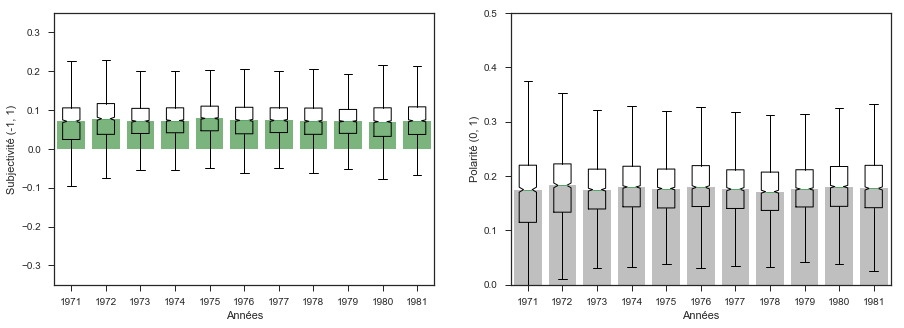

In [116]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(np.arange(len(years))+1, median_subj, color = '#7CB47D')
ax1.boxplot(subjectivity, notch = True);

ax2.bar(np.arange(len(years))+1, median_pol, color = '#BFBFBF')
ax2.boxplot(polarity, notch = True);

ax1.set_ylim((-0.35, 0.35))
ax2.set_ylim((0, 0.5))

ax1.set_ylabel('Subjectivité (-1, 1)')
ax2.set_ylabel('Polarité (0, 1)')

ax1.set_xlabel('Années')
ax2.set_xlabel('Années')

ax1.set_xticklabels(years)
ax2.set_xticklabels(years)

plt.show();

In [117]:
lower_bound, mean, upper_bound = [], [], []
lower_bound_, mean_, upper_bound_ = [], [], []

# Compute the 95% confidence interval
for i in range(len(polarity)):
    m, lb, ub = mean_confidence_interval(polarity[i])
    
    lower_bound.append(lb)
    mean.append(m)
    upper_bound.append(ub)
    
for i in range(len(subjectivity)):
    m, lb, ub = mean_confidence_interval(subjectivity[i])
    
    lower_bound_.append(lb)
    mean_.append(m)
    upper_bound_.append(ub)

In [118]:
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("ticks")

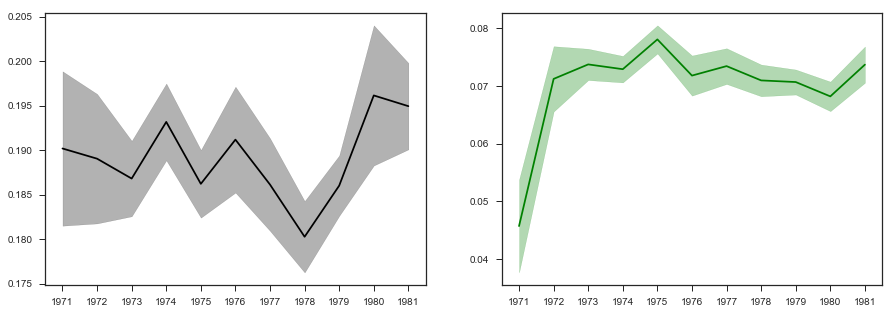

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.fill_between(range(len(mean)), upper_bound, lower_bound, color = 'k', alpha=.3)
ax1.plot(mean, 'k')

ax2.fill_between(range(len(mean_)), upper_bound_, lower_bound_, color = 'g', alpha=.3)
ax2.plot(mean_, 'g')

ax1.set_xticks(np.arange(len(years)))
ax2.set_xticks(np.arange(len(years)))

ax1.set_xticklabels(years)
ax2.set_xticklabels(years)

plt.show();

In [120]:
subjectivity, polarity = [], []
median_subj, median_pol = [], []

for page in pages:
    #distribution = np.random.uniform(0, len(df_corpus[df_corpus['page'] == page]) - 1, 5000).astype('int')
    
    subjectivity_, polarity_ = [], []
    
    df_ = df_corpus[df_corpus['page'] == page]

    for ind, item in df_['text'].iteritems():
        blob = TextBlob(item, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
        subjectivity_.append(blob[0])
        polarity_.append(blob[1])
        
    subjectivity.append(subjectivity_)
    polarity.append(polarity_)
    median_subj.append(np.median(subjectivity_))
    median_pol.append(np.median(polarity_))

In [126]:
sns.set(rc={'figure.figsize':(25,14)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2)

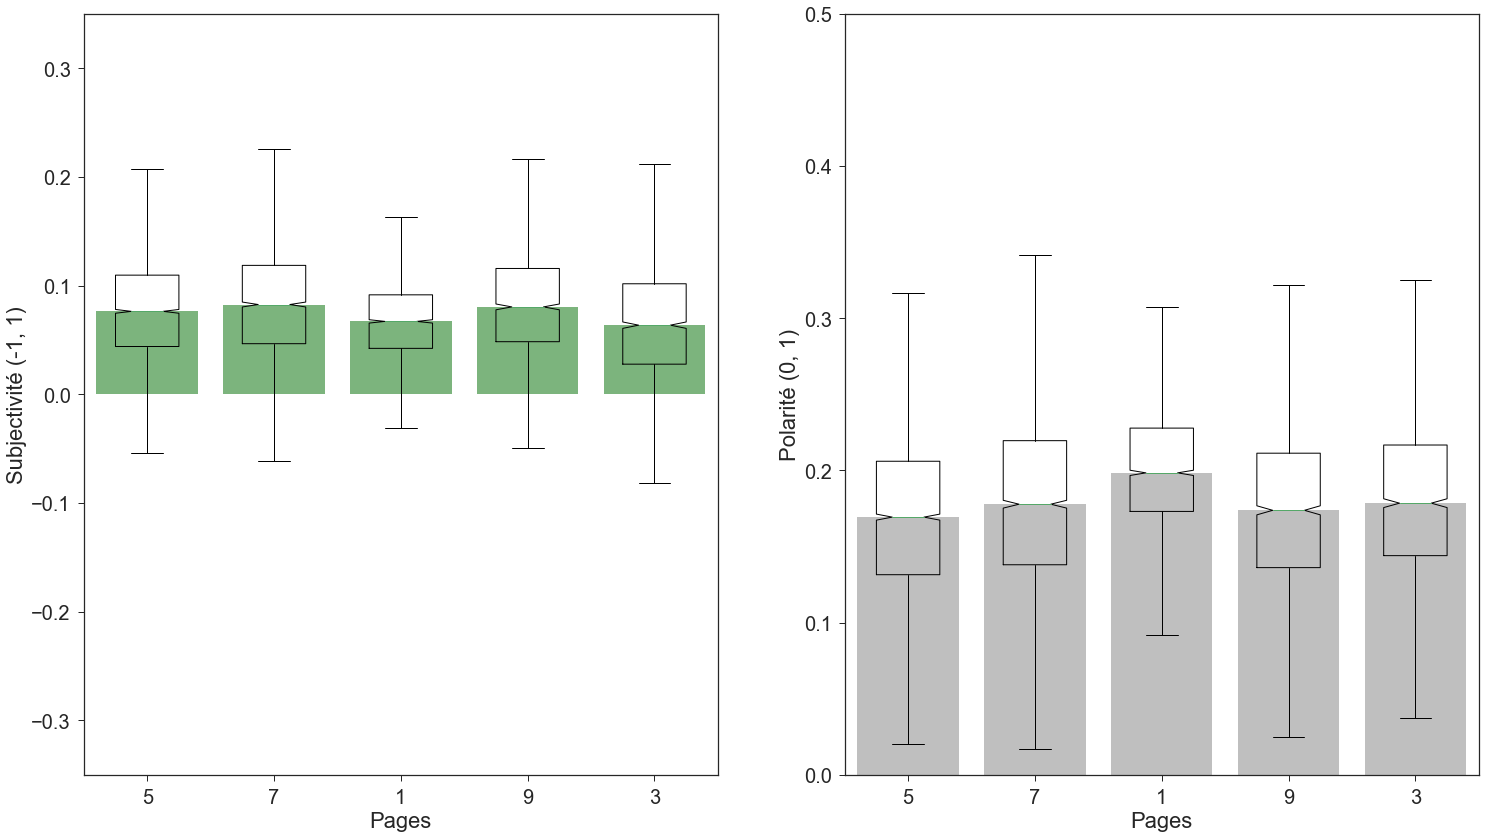

In [127]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(np.arange(len(pages))+1, median_subj, color = '#7CB47D')
ax1.boxplot(subjectivity, notch = True);

ax2.bar(np.arange(len(pages))+1, median_pol, color = '#BFBFBF')
ax2.boxplot(polarity, notch = True);

ax1.set_ylim((-0.35, 0.35))
ax2.set_ylim((0, 0.5))

ax1.set_ylabel('Subjectivité (-1, 1)')
ax2.set_ylabel('Polarité (0, 1)')

ax1.set_xlabel('Pages')
ax2.set_xlabel('Pages')

ax1.set_xticklabels(pages)
ax2.set_xticklabels(pages)

plt.show();